In [2]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy.stats import skew, kurtosis
from itertools import product
import multiprocessing as mp
import json
import os
import seaborn as sns
from tqdm import tqdm

###############################################################################
# 1) PIPELINE CONFIGURATION
###############################################################################

PIPELINE_CONFIG = {
    "sf_hbar": 1,
    "quad_range": (-6, 6),
    "quad_points": 200,  # used for Wigner or marginal computations
    "num_shots": 100,    # for homodyne measurements (unused in this snippet, which focuses on marginals)
    "grid": {
        "num_db": 20,
        "num_loss": 20,
        "num_gamma": 20
    },
    "db_range": (10.0, 13.0),
    "loss_range": (0.8, 1.0),
    "gamma_range": (0.8, 1.0),
    "model": {
        "input_shape": (8,),  # we are extracting 8-dimensional features
        "learning_rate": 1e-3,
        "epochs": 3000,          # reduce for demonstration
        "batch_size": 32,
        "validation_split": 0
    },
    "save_paths": {
        "dataset": "dataset_joint.npz",
        "model": "trained_model_joint.h5",
        "config": "pipeline_config_joint.json"
    }
}



###############################################################################
# 2) SETUP: CONFIGURATION & GLOBALS
###############################################################################
print("Setting configuration parameters.")
CONFIG = {
    "hbar": PIPELINE_CONFIG["sf_hbar"],
    "quad_range": PIPELINE_CONFIG["quad_range"],
    "quad_points": PIPELINE_CONFIG["quad_points"]
}
sf.hbar = CONFIG["hbar"]

# For scaling quadrature axis in Wigner or marginals:
CONFIG["scale"] = np.sqrt(CONFIG["hbar"] * np.pi)
print("Configuration set. Scale =", CONFIG["scale"])

###############################################################################
# 3) HELPER FUNCTIONS
###############################################################################

def db_to_epsilon(db_val: float) -> float:
    """
    Convert a given GKP squeezing level in dB to epsilon:
         tanh(epsilon) = 10^(-db_val/10).
    """
    t = 10.0 ** (-db_val / 10.0)
    eps = 0.5 * np.log((1.0 + t) / (1.0 - t))
    return eps


def calculate_ideal_marginals(prep_state: List[float], epsilon: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculate the ideal X and P marginal distributions with no noise.
    """
    prog = sf.Program(1)
    with prog.context as q:
        sf.ops.GKP(state=prep_state, epsilon=epsilon) | q
    state = sf.Engine("bosonic").run(prog).state
    quad_axis = np.linspace(*CONFIG["quad_range"], 1000) * CONFIG["scale"]
    marg_x = state.marginal(0, quad_axis, phi=0) * CONFIG["scale"]
    marg_p = state.marginal(0, quad_axis, phi=np.pi/2) * CONFIG["scale"]
    return marg_x, marg_p


def calculate_noisy_marginals(prep_state: List[float], epsilon: float, noise_params: Dict) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculate the noisy X and P marginals under LossChannel and dephasing (Rgate).
    We do repeated simulations for averaging.
    """
    quad_axis = np.linspace(*CONFIG["quad_range"], 1000) * CONFIG["scale"]
    num_avg = 100  # repeated sampling to approximate the average
    marg_x = np.zeros_like(quad_axis)
    marg_p = np.zeros_like(quad_axis)

    for _ in range(num_avg):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=prep_state, epsilon=epsilon) | q
            if 'loss' in noise_params:
                sf.ops.LossChannel(noise_params['loss']) | q
            if 'gamma' in noise_params:
                # random dephasing rotation
                theta = np.random.normal(0, np.sqrt(2 * noise_params['gamma']))
                sf.ops.Rgate(theta) | q
        state = sf.Engine("bosonic").run(prog).state
        marg_x += state.marginal(0, quad_axis, phi=0)
        marg_p += state.marginal(0, quad_axis, phi=np.pi/2)

    return ((marg_x / num_avg) * CONFIG["scale"], 
            (marg_p / num_avg) * CONFIG["scale"])


def extract_marginal_features(prep_state: List[float], epsilon: float, noise_params: Dict) -> np.ndarray:
    """
    Extract a 10-dimensional feature vector from ideal & noisy marginals:
      - [mean_x_noisy, var_x_noisy, skew_x_noisy, kurt_x_noisy,
         mean_p_noisy, var_p_noisy, skew_p_noisy, kurt_p_noisy,
         MAE(ideal_x,noisy_x), MAE(ideal_p,noisy_p)]
    """
    from scipy.stats import skew, kurtosis
    
    ideal_x, ideal_p = calculate_ideal_marginals(prep_state, epsilon)
    noisy_x, noisy_p = calculate_noisy_marginals(prep_state, epsilon, noise_params)

    feats = [
        np.mean(noisy_x), np.var(noisy_x), skew(noisy_x), kurtosis(noisy_x),
        np.mean(noisy_p), np.var(noisy_p), skew(noisy_p), kurtosis(noisy_p)
    ]
    diff_x = np.mean(np.abs(ideal_x - noisy_x))
    diff_p = np.mean(np.abs(ideal_p - noisy_p))
    feats.extend([diff_x, diff_p])

    return np.array(feats)

def simulate_homodyne(prep_state: List[float], epsilon: float, noise_params: Dict, num_samples: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simulate homodyne measurements (X and P quadratures) for a given epsilon and noise parameters.
    Returns two arrays of measurement outcomes.
    """
    samples_x, samples_p = [], []
    for _ in range(num_samples):
        prog_x = sf.Program(1)
        with prog_x.context as q:
            sf.ops.GKP(state=prep_state, epsilon=epsilon) | q
            if 'loss' in noise_params:
                sf.ops.LossChannel(noise_params['loss']) | q
            if 'gamma' in noise_params:
                theta = np.random.normal(0, np.sqrt(2 * noise_params['gamma']))
                sf.ops.Rgate(theta) | q
            sf.ops.MeasureX | q
        eng_x = sf.Engine("bosonic")
        sample_x = eng_x.run(prog_x).samples[0, 0] / CONFIG["scale"]
        samples_x.append(sample_x)
        
        prog_p = sf.Program(1)
        with prog_p.context as q:
            sf.ops.GKP(state=prep_state, epsilon=epsilon) | q
            if 'loss' in noise_params:
                sf.ops.LossChannel(noise_params['loss']) | q
            if 'gamma' in noise_params:
                theta = np.random.normal(0, np.sqrt(2 * noise_params['gamma']))
                sf.ops.Rgate(theta) | q
            sf.ops.MeasureP | q
        eng_p = sf.Engine("bosonic")
        sample_p = eng_p.run(prog_p).samples[0, 0] / CONFIG["scale"]
        samples_p.append(sample_p)
    
    return np.array(samples_x), np.array(samples_p)

Setting configuration parameters.
Configuration set. Scale = 1.7724538509055159


In [3]:
def build_joint_fnn_model(input_shape: Tuple[int], num_loss: int, num_gamma: int) -> Model:
    num_classes = num_loss * num_gamma
    inputs = Input(shape=input_shape, name='features')
    
    x = Dense(512, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    joint_output = Dense(num_classes, activation='softmax', name='joint_output')(x)
    model = Model(inputs=inputs, outputs=joint_output)
    return model


Total examples: 16000. Feature shape: (16000, 8)
Training set size = 14400
Test set size = 1600


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ joint_output (Dense)            │ (None, 400)            │        51,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499,600 (1.91 MB)

 Trainable params: 499,600 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

Starting model training...
Epoch 1/1000
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0030 - loss: 5.9984 - val_accuracy: 0.0049 - val_loss: 5.9862 - learning_rate: 0.0010
Epoch 2/1000
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0032 - loss: 5.9773 - val_accuracy: 0.0049 - val_loss: 5.8851 - learning_rate: 0.0010
Epoch 3/1000
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0022 - loss: 5.9353 - val_accuracy: 0.0056 - val_loss: 5.8922 - learning_rate: 0.0010
Epoch 4/1000
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0042 - loss: 5.9017 - val_accuracy: 0.0059 - val_loss: 5.7892 - learning_rate: 0.0010
Epoch 5/1000
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0034 - loss: 5.8803 - val_accuracy: 0.0056 - val_loss: 5.8083 - learning_rate: 0.0010
Epoch 6/1000
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0036 - loss: 5.8683 - val_accuracy: 0.0052 - val_loss: 5.7226 - learning_rate: 0.0010
Epoch 7/1000
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

Trained model saved to trained_model_joint.h5


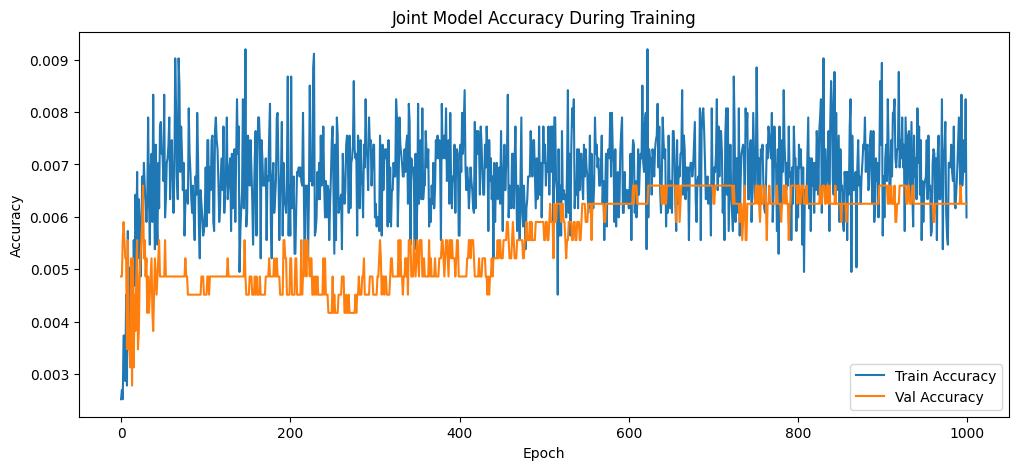

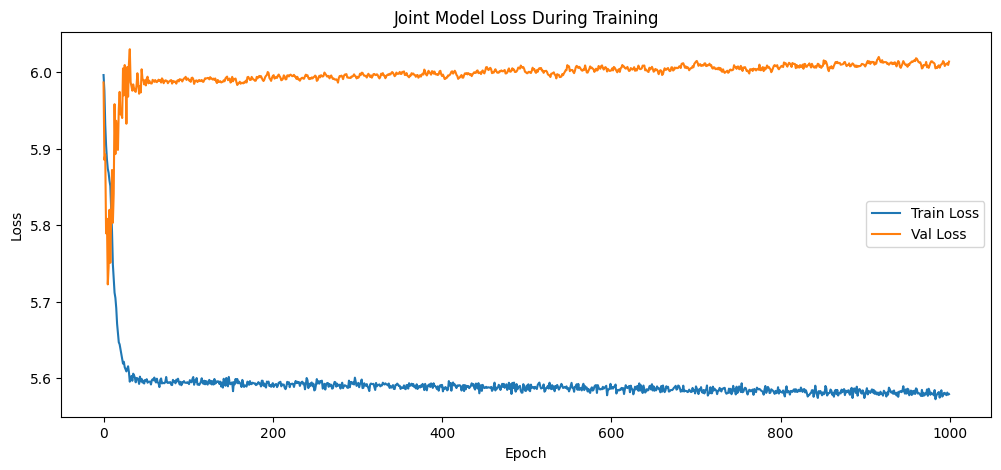

Evaluating on test set...
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
Test Accuracy: 0.31%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           7       0.07      0.25      0.11         4
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         4
          10       0.01      0.75      0.03         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         4
          15       0.00 

c:\Users\tvle2\AppData\Local\anaconda3\envs\cv_Computing\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\tvle2\AppData\Local\anaconda3\envs\cv_Computing\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\tvle2\AppData\Local\anaconda3\envs\cv_Computing\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


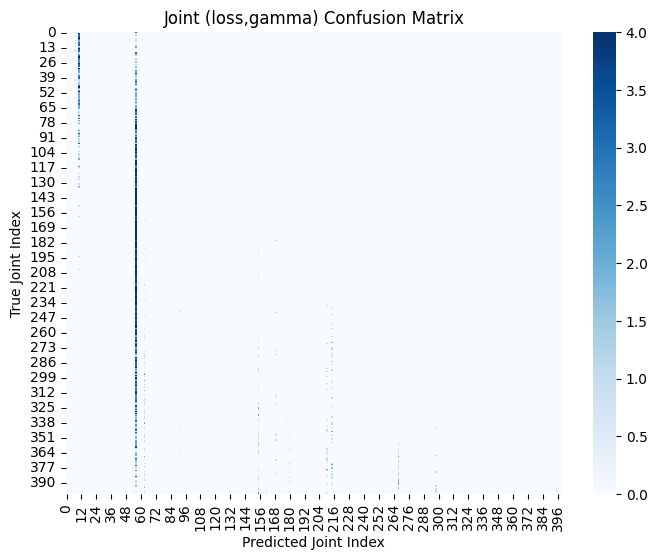

In [16]:
if __name__ == '__main__':

    dataset_path = "C:/Users/tvle2/Documents/Code/Bosonic/dataset.npz"
    # os.makedirs(os.path.dirname(dataset_path), exist_ok=True)

    # Parameter grids
    num_db = PIPELINE_CONFIG["grid"]["num_db"]
    num_loss = PIPELINE_CONFIG["grid"]["num_loss"]
    num_gamma = PIPELINE_CONFIG["grid"]["num_gamma"]
    
    db_values = np.linspace(PIPELINE_CONFIG["db_range"][0], PIPELINE_CONFIG["db_range"][1], num_db)
    loss_values = np.linspace(PIPELINE_CONFIG["loss_range"][0], PIPELINE_CONFIG["loss_range"][1], num_loss)
    gamma_values = np.linspace(PIPELINE_CONFIG["gamma_range"][0], PIPELINE_CONFIG["gamma_range"][1], num_gamma)
    
    # GKP prep states (just an example)
    prep_states = [[0, 0], [np.pi, 0]]

    # Cartesian product of (prep_state, db, loss, gamma)
    grid_params = list(product(prep_states, db_values, loss_values, gamma_values))

    # # 5A) Generate or load the dataset
    # if not os.path.exists(dataset_path):
    #     print("No dataset found -> Generating new dataset (this might take a while).")
    #     results = []
    #     for params in tqdm(grid_params, total=len(grid_params)):
    #         feats, j_idx = process_grid_point(params, db_values, loss_values, gamma_values)
    #         results.append((feats, j_idx))
        
    #     X_data, y_joint = zip(*results)
    #     X_data = np.array(X_data)       # shape (N, 10)
    #     y_joint = np.array(y_joint)     # shape (N,)
        
    #     np.savez_compressed(dataset_path, X_data=X_data, y_joint=y_joint)
    #     print(f"Dataset saved to {dataset_path}")
    # else:
    #     print("Dataset found. Loading from disk:", dataset_path)
    data = np.load(dataset_path)
    X_data = data["X_data"][:, :8]
    y_loss = data["y_loss"]           
    y_dephasing = data["y_dephasing"]
    y_joint = y_loss * num_gamma + y_dephasing

    num_examples = X_data.shape[0]
    print(f"Total examples: {num_examples}. Feature shape: {X_data.shape}")

    ###############################################################################
    # 6) TRAIN / TEST SPLIT
    ###############################################################################
    split_idx = int(0.9 * num_examples)
    X_train, X_test = X_data[:split_idx], X_data[split_idx:]
    y_train, y_test = y_joint[:split_idx], y_joint[split_idx:]
    
    print("Training set size =", X_train.shape[0])
    print("Test set size =", X_test.shape[0])

    ###############################################################################
    # 7) BUILD & TRAIN THE JOINT-OUTPUT MODEL
    ###############################################################################
    model_config = PIPELINE_CONFIG["model"]
    input_shape = model_config["input_shape"]
    
    model = build_joint_fnn_model(input_shape, num_loss, num_gamma)
    model.compile(
        optimizer=Adam(learning_rate=model_config["learning_rate"]),
        loss='sparse_categorical_crossentropy',  # single integer label
        metrics=['accuracy']
    )
    
    model.summary()
    print("Starting model training...")
    
    reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # watch the validation loss
    factor=0.5,           # when triggered, reduce LR by 1/2
    patience=5,           # wait 5 epochs with no improvement before reducing
    verbose=1,            # print messages
    min_lr=1e-6           # don't go below this
    )

    history = model.fit(
        X_train, y_train,
        epochs=model_config["epochs"],
        batch_size=model_config["batch_size"],
        validation_split=model_config["validation_split"],
        callbacks=[reduce_lr],
        verbose=1
    )

    # Save the trained model
    model_path = PIPELINE_CONFIG["save_paths"]["model"]
    model.save(model_path)
    print(f"Trained model saved to {model_path}")

    ###############################################################################
    # 8) PLOT TRAINING CURVES
    ###############################################################################
    plt.figure(figsize=(12,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Joint Model Accuracy During Training')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Joint Model Loss During Training')
    plt.legend()
    plt.show()

    ###############################################################################
    # 9) EVALUATE ON TEST SET
    ###############################################################################
    print("Evaluating on test set...")
    pred_probs = model.predict(X_test)  # shape (test_size, num_loss*num_gamma)
    preds = np.argmax(pred_probs, axis=1)
    
    acc = accuracy_score(y_test, preds)
    print(f"Test Accuracy: {acc * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, preds))
    
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
    plt.title("Joint (loss,gamma) Confusion Matrix")
    plt.xlabel("Predicted Joint Index")
    plt.ylabel("True Joint Index")
    plt.show()



Total examples: 16000. Feature shape: (16000, 8)
Training set size = 16000
Test set size = 0


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ joint_output (Dense)            │ (None, 400)            │        51,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499,600 (1.91 MB)

 Trainable params: 499,600 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

Starting model training...
Epoch 1/3000
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0020 - loss: 5.9911 - learning_rate: 0.0010
Epoch 2/3000
102/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0014 - loss: 5.8936    

c:\Users\tvle2\AppData\Local\anaconda3\envs\cv_Computing\lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0031 - loss: 5.8959 - learning_rate: 0.0010
Epoch 3/3000
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0042 - loss: 5.8558 - learning_rate: 0.0010
Epoch 4/3000
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0044 - loss: 5.8301 - learning_rate: 0.0010
Epoch 5/3000
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0034 - loss: 5.8202 - learning_rate: 0.0010
Epoch 6/3000
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0037 - loss: 5.8055 - learning_rate: 0.0010
Epoch 7/3000
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0051 - loss: 5.7945 - learning_rate: 0.0010
Epoch 8/3000
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0056 - loss: 5.7981 - learning_rate: 0.0010
Epoch 9/3000
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0044 - loss: 5.7649 - learning_rate: 0.0010
Epoch 10/3000
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0057 - loss: 5.7473 - learning_rate: 0.0010
Epoc

Trained model saved to trained_model_joint.h5


KeyError: 'val_accuracy'

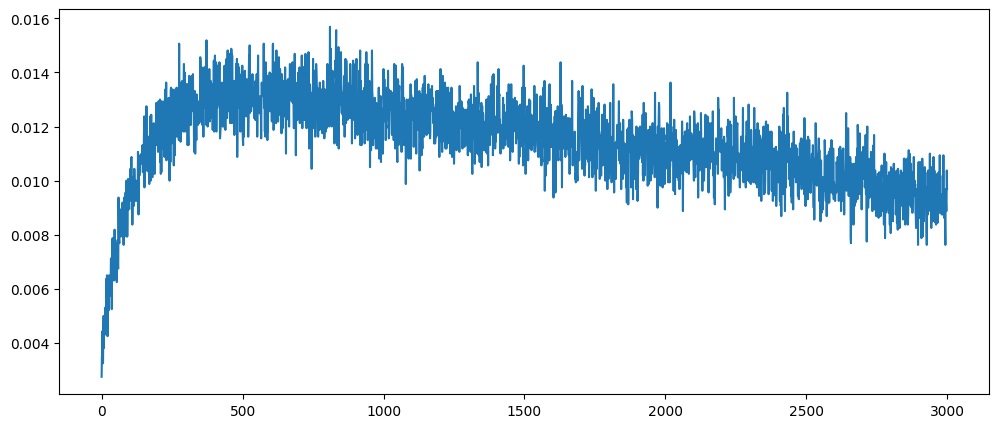

In [12]:
if __name__ == '__main__':

    dataset_path = "C:/Users/tvle2/Documents/Code/Bosonic/dataset.npz"

    # Parameter grids
    num_db = PIPELINE_CONFIG["grid"]["num_db"]
    num_loss = PIPELINE_CONFIG["grid"]["num_loss"]
    num_gamma = PIPELINE_CONFIG["grid"]["num_gamma"]
    
    db_values = np.linspace(PIPELINE_CONFIG["db_range"][0], PIPELINE_CONFIG["db_range"][1], num_db)
    loss_values = np.linspace(PIPELINE_CONFIG["loss_range"][0], PIPELINE_CONFIG["loss_range"][1], num_loss)
    gamma_values = np.linspace(PIPELINE_CONFIG["gamma_range"][0], PIPELINE_CONFIG["gamma_range"][1], num_gamma)
    
    # GKP prep states (just an example)
    prep_states = [[0, 0], [np.pi, 0]]

    # Cartesian product of (prep_state, db, loss, gamma)
    grid_params = list(product(prep_states, db_values, loss_values, gamma_values))
    data = np.load(dataset_path)

    X_data = data["X_data"][:, :8]
    y_loss = data["y_loss"]           
    y_dephasing = data["y_dephasing"]
    y_joint = y_loss * num_gamma + y_dephasing

    num_examples = X_data.shape[0]
    print(f"Total examples: {num_examples}. Feature shape: {X_data.shape}")

    ###############################################################################
    # 6) TRAIN / TEST SPLIT
    ###############################################################################
    split_idx = int(1 * num_examples)
    X_train, X_test = X_data[:split_idx], X_data[split_idx:]
    y_train, y_test = y_joint[:split_idx], y_joint[split_idx:]
    
    print("Training set size =", X_train.shape[0])
    print("Test set size =", X_test.shape[0])

    ###############################################################################
    # 7) BUILD & TRAIN THE JOINT-OUTPUT MODEL
    ###############################################################################
    model_config = PIPELINE_CONFIG["model"]
    input_shape = model_config["input_shape"]
    
    model = build_joint_fnn_model(input_shape, num_loss, num_gamma)
    model.compile(
        optimizer=Adam(learning_rate=model_config["learning_rate"]),
        loss='sparse_categorical_crossentropy',  # single integer label
        metrics=['accuracy']
    )
    
    model.summary()
    print("Starting model training...")
    
    reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # watch the validation loss
    factor=0.5,           # when triggered, reduce LR by 1/2
    patience=5,           # wait 5 epochs with no improvement before reducing
    verbose=1,            # print messages
    min_lr=1e-6           # don't go below this
    )

    history = model.fit(
        X_train, y_train,
        epochs=model_config["epochs"],
        batch_size=model_config["batch_size"],
        validation_split=model_config["validation_split"],
        callbacks=[reduce_lr],
        verbose=1
    )

    # Save the trained model
    model_path = PIPELINE_CONFIG["save_paths"]["model"]
    model.save(model_path)
    print(f"Trained model saved to {model_path}")

    ###############################################################################
    # 8) PLOT TRAINING CURVES
    ###############################################################################
    plt.figure(figsize=(12,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Joint Model Accuracy During Training')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Joint Model Loss During Training')
    plt.legend()
    plt.show()

    ###############################################################################
    # 9) EVALUATE ON TEST SET
    ###############################################################################
    print("Evaluating on test set...")
    pred_probs = model.predict(X_test)  # shape (test_size, num_loss*num_gamma)
    preds = np.argmax(pred_probs, axis=1)
    
    acc = accuracy_score(y_test, preds)
    print(f"Test Accuracy: {acc * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, preds))
    
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
    plt.title("Joint (loss,gamma) Confusion Matrix")
    plt.xlabel("Predicted Joint Index")
    plt.ylabel("True Joint Index")
    plt.show()

In [18]:
def extract_marginal_features(prep_state: List[float], epsilon: float, noise_params: Dict) -> np.ndarray:
    """
    Extract features from the marginal distributions:
      - Compute ideal and noisy marginals (for both X and P)
      - Compute statistical moments (mean, var, skew, kurtosis) from the noisy marginals
      - Compute a difference metric (mean absolute difference) between ideal and noisy marginals
    Returns a feature vector of length 10.
    """
    # Compute marginals using provided functions.
    ideal_x, ideal_p = calculate_ideal_marginals(prep_state, epsilon)
    noisy_x, noisy_p = calculate_noisy_marginals(prep_state, epsilon, noise_params)
    
    # Compute moments for the noisy marginals.
    features = [
        np.mean(noisy_x), np.var(noisy_x), skew(noisy_x), kurtosis(noisy_x),
        np.mean(noisy_p), np.var(noisy_p), skew(noisy_p), kurtosis(noisy_p)
    ]
    # Compute difference metrics (mean absolute difference).
    diff_x = np.mean(np.abs(ideal_x - noisy_x))
    diff_p = np.mean(np.abs(ideal_p - noisy_p))
    features.extend([diff_x, diff_p])
    
    return np.array(features)

# Example new input parameters
prep_state = [0, 0]         # or another valid state representation
db_value = 11.0             # a sample squeezing level in dB
epsilon = db_to_epsilon(db_value)
noise_params = {"loss": 0.9, "gamma": 0.85}  # sample noise parameters


feature_vector = extract_marginal_features(prep_state, epsilon, noise_params)

# Ensure the feature is 2D (batch size, feature_dim) before prediction:
feature_vector = feature_vector.reshape(1, -1)
feature_vector = feature_vector[:, :8]

pred_probs = model.predict(feature_vector)  # shape: (1, num_classes)
# Get the predicted class index
predicted_index = np.argmax(pred_probs, axis=1)[0]
#185
print("Predicted joint index:", predicted_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted joint index: 159


In [12]:
noise_params = {"loss": 0.9, "gamma": 0.85}
noisy_x, noisy_p = calculate_noisy_marginals([0, 0], db_to_epsilon(11), noise_params)

print(np.mean(noisy_x), np.var(noisy_x), skew(noisy_x), kurtosis(noisy_x))
print(np.mean(noisy_p), np.var(noisy_p), skew(noisy_p), kurtosis(noisy_p))
print("============ \n")


0.08324925889193463 0.011987100140788827 1.4599763729515975 1.6470474009255618
0.08324930194215831 0.011635920307128088 1.3353847752910117 1.056628125180314



0.08324929739854928 0.011467594878085912 1.3109950010115832 1.03056735815243
0.08324930159592449 0.011982376458983899 1.4218442239149964 1.4356862628037588


0.08324928736345148 0.011548660423571378 1.3057771908918996 0.9132892123852523
0.08324929419105839 0.011858163187857866 1.4061204529016285 1.3918023800217973


0.08324928557856476 0.011519159754094907 1.2817892166422207 0.7386999654472941
0.08324926921097281 0.011600464037206205 1.3272064175013192 0.9751112373486097

0.08324928766076459 0.011949323547223938 1.4718070141026809 1.8008877911258425
0.08324929954440184 0.011906094122968752 1.4239955592052043 1.5035375801207094




